# Flood Hydrograph Reconstruction & Estimation

Regression: smooth out data and fill in any gaps.

Root-finding: to determine when flooding begins and ends

Numerical integration: to compute flood volume above the threshold.

---

## What is a flood hydrograph

A hydrograph is a graph showing river discharge and rainfall over time. A flood hydrograph is used to prediect floods by showing the amount of rainfall and river discharge (flow rate) in an area. The base flow is the normal discharge of the river and is usually from ground water or rocks below the water table seeping into the river channel. As rainwater enters the bank, the discharge rates increase. If it is within the Bankful discharge, the river will not start to flood over.

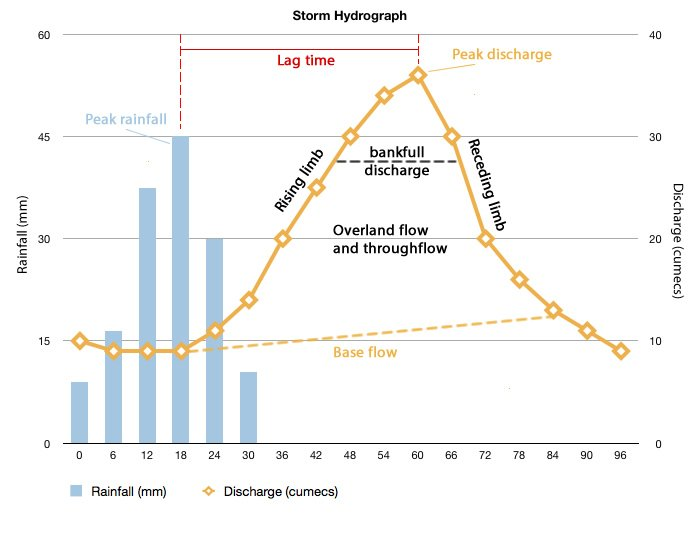


https://www.internetgeography.net/topics/flood-hydrographs/


---



## Using Regression to create hydrograph

To fill in data gaps from observed data to get finer time steps and creating a continuous and detailed hydrograph

Why?
- more detailed data
- so root finding can identify flood start/end times

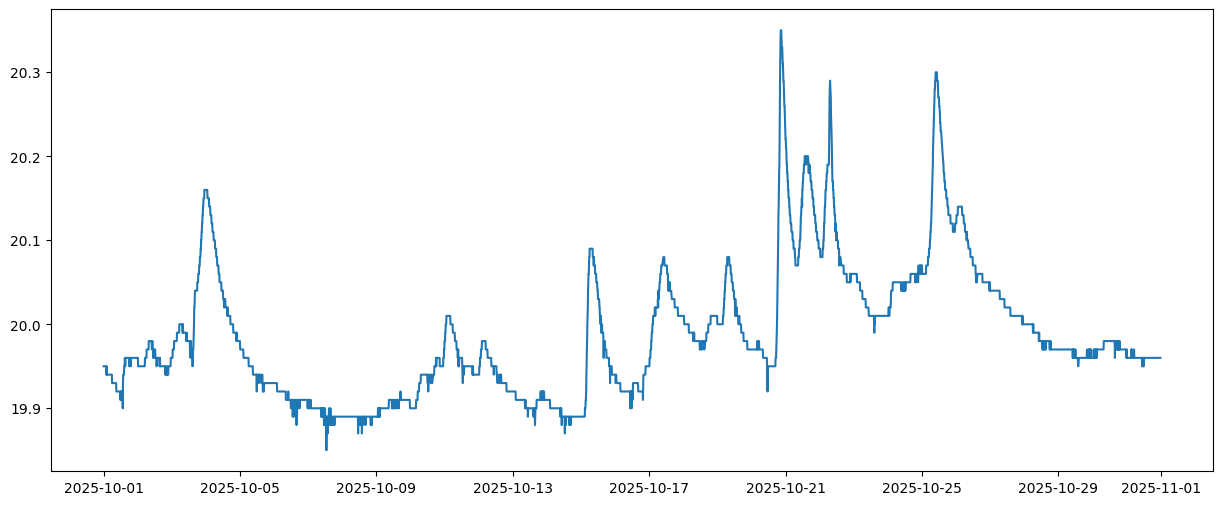

In [11]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

data = pd.read_csv("MDC005.csv") # from Hydro Informatics Institute (Public Organization)
data["measure_datetime"] = pd.to_datetime(data["measure_datetime"])
data = data[data["quality_flag"] == "N"] #only get valid data


plt.figure(figsize=(15, 6)) 
plt.plot(data["measure_datetime"], data["water_level"])
plt.show()

Since there's a peak around the 20th of October.

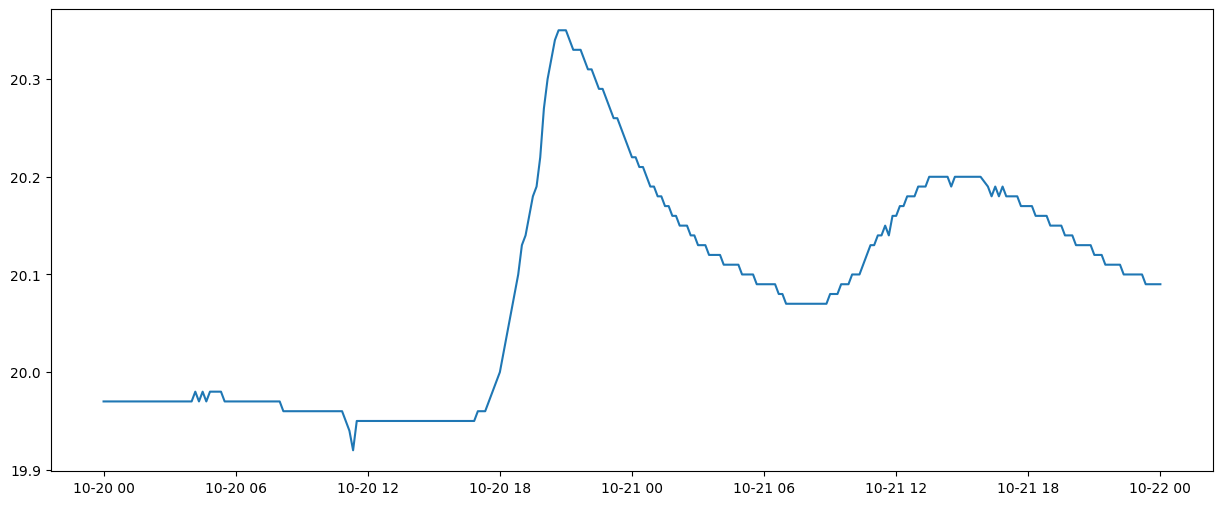

In [12]:
start_date = "2025-10-20"
end_date = "2025-10-22" 
mask = (data["measure_datetime"] >= start_date) & (data["measure_datetime"] <= end_date)
filtered_data = data[mask]

xs = filtered_data["measure_datetime"]
ys = filtered_data["water_level"]

plt.figure(figsize=(15, 6)) 
plt.plot(xs, ys)
plt.show()

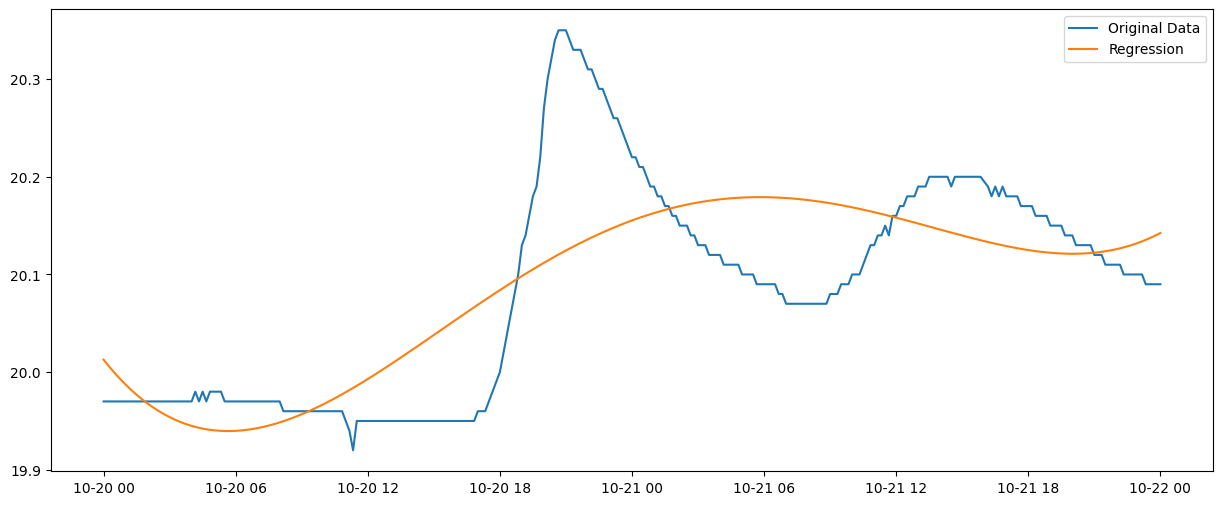

In [13]:
# Convert datetime to numeric
t0 = filtered_data["measure_datetime"].iloc[0]
xs = (filtered_data["measure_datetime"] - t0).dt.total_seconds().values
ys = filtered_data["water_level"].values

coeffs = np.polyfit(xs, ys, deg=4) # Least Squares polynomial regression
poly = np.poly1d(coeffs) # Creating a polynomial from coefficient

new_x = np.arange(0, xs[-1]+1, 300)  # every 5 minutes
new_y = poly(new_x)

# Convert back to datetime
time = [t0 + pd.Timedelta(seconds=x) for x in new_x]

plt.figure(figsize=(15, 6)) 
plt.plot(filtered_data["measure_datetime"], ys, label='Original Data')
plt.plot(time, new_y, '-', label='Regression')
plt.legend()
plt.show()

regression fits a curve

$$ water\_level(t) = a_0 + a_1t + a_2t^2 + a_3t^3 + a_4t^4 $$

and then uses the Least Squares method to find the coefficient. The regression creates a smooth trend, but not a perfect fit. It can't capture sudden jumps but it's a close approximation.

## Other methods?

- lagrange interpolation: wouldn't work well because of the amount of points

---

## Root finding to find when it floods

To find the exact time when the river discharge crosses the flood threshold. A flood threshold is usually gathered by analyzing historical discharge


$$f(t) = water\_level(t) - flood\_threshold = 0$$


if
- $f(t) < 0$ : below flood level
- $f(t) > 0$ : above flood level
- $f(t) < 0$ : exactly at flood level (what we're trying to find)



Suppose the flood threshold is 20 meters:

In [14]:
threshold = 20

def f(t):
    return poly(t) - threshold

def bisection_method(f, a, b, tol=1e-6, max_iter=100):
    if f(a) * f(b) >= 0:
        print("f(a) and f(b) must have opposite signs.")
        return None
    
    iteration = 0
    while (b - a) / 2.0 > tol and iteration < max_iter:
        m = (a + b) / 2.0
        
        if abs(f(m)) < tol:
            return m
        elif f(a) * f(m) < 0:
            b = m
        else: a = m
        iteration += 1
    return (a + b) / 2.0

roots = []
for i in range(len(new_x)-1):
    if f(new_x[i]) * f(new_x[i+1]) < 0:
        root = bisection_method(f, new_x[i], new_x[i+1])
        root_time = t0 + pd.Timedelta(seconds=float(root))
        roots.append(root_time)

print("Flood threshold crossings:", roots)

Flood threshold crossings: [Timestamp('2025-10-20 00:28:16.875000'), Timestamp('2025-10-20 12:29:46.523437500')]


## Why not Newton-Raphson

Here Bisection is easier to implement since we don't need to find the derivative.

---

## Figure out flood volume

by testing trapezoid rule integration

In [15]:
def trapezoid(x, y):
    n = len(x)
    T = 0.0
    for i in range(n - 1):
        dx = x[i+1] - x[i]       
        height = (y[i] + y[i+1]) / 2
        T += height * dx
    return T 


# Compute excess water above threshold
excess_y = np.maximum(0, new_y - threshold)

# Integrate using trapezoid
flood_volume_sec = trapezoid(new_x, excess_y)
flood_volume_hours = flood_volume_sec / 3600

print("Flood volume (meter/seconds):", flood_volume_sec)
print("Flood volume (meter/hours):", flood_volume_hours)


Flood volume (meter/seconds): 16661.404757557757
Flood volume (meter/hours): 4.628167988210488


---

## Limitations

- Noise in the raw data: sometimes there might be missing gaps in the data or the water level is unstable

- Overfitting: noise or random fluctuations can cause the regressoin to be inaccurate

- Stable water levels -> no flood

---

## Conclusion

In this project regression, root-finding and numerical integration were used reconstruct a continuous hydrograph and estimate flood. This shows how numerical methods can be used to create a hydrograph, detect when it floods and estimate the volume of the floods. It also shows that the accuracy of the outcome also depends on the original data. 